## Задача

В этом проекте используется датасет с данными детей с подозрением на аппендицит. Цель — на основе признаков и клинических данных построить модели классификации, предсказывающие, болен ли ребёнок аппендицитом.

In [ ]:
!pip install ucimlrepo >> None

# Загружаем датасет

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

# data (as pandas dataframes)
X = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

# metadata
print(regensburg_pediatric_appendicitis.metadata)

# variable information
print(regensburg_pediatric_appendicitis.variables)


{'uci_id': 938, 'name': 'Regensburg Pediatric Appendicitis', 'repository_url': 'https://archive.ics.uci.edu/dataset/938/regensburg+pediatric+appendicitis', 'data_url': 'https://archive.ics.uci.edu/static/public/938/data.csv', 'abstract': 'This repository holds the data from a cohort of pediatric patients with suspected appendicitis admitted with abdominal pain to Children’s Hospital St. Hedwig in Regensburg, Germany, between 2016 and 2021. Each patient has (potentially multiple) ultrasound (US) images, aka views, tabular data comprising laboratory, physical examination, scoring results and ultrasonographic findings extracted manually by the experts, and three target variables, namely, diagnosis, management and severity.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular', 'Image'], 'num_instances': 782, 'num_features': 53, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Sex'], 'target_col': ['Management', 'Severity',

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.concat([X, y], axis=1)

В этом датасете хранятся данные группы детей с подозрением на аппендицит, поступивших с болью в животе в детскую больницу Св. Ядвиги в Регенсбурге, Германия, в период с 2016 по 2021 год. У каждого пациента есть (возможно, несколько) ультразвуковых (УЗ) изображений, также известных как виды, табличные данные, включающие лабораторные данные, результаты физического обследования, оценки и данные ультразвукового исследования, полученные вручную экспертами, а также три целевые переменные, а именно: диагноз, лечение и тяжесть.

# EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 56 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Alvarado_Score                    730 non-null    float64
 7   Paedriatic_Appendicitis_Score     730 non-null    float64
 8   Appendix_on_US                    777 non-null    object 
 9   Appendix_Diameter                 498 non-null    float64
 10  Migratory_Pain                    773 non-null    object 
 11  Lower_Right_Abd_Pain              774 non-null    object 
 12  Contrala

In [ ]:
print("Размер датасета:", df.shape)
print("Количество дубликатов:", df.duplicated().sum())
print("Содержит NaN:", df.isnull().any().any())
print("Пропущенные значения:")
print(df.isnull().sum())
df[df.isnull().all(axis=1)]

Размер датасета: (782, 56)
Количество дубликатов: 0
Содержит NaN: True
Пропущенные значения:
Age                                   1
BMI                                  27
Sex                                   2
Height                               26
Weight                                3
Length_of_Stay                        4
Alvarado_Score                       52
Paedriatic_Appendicitis_Score        52
Appendix_on_US                        5
Appendix_Diameter                   284
Migratory_Pain                        9
Lower_Right_Abd_Pain                  8
Contralateral_Rebound_Tenderness     15
Coughing_Pain                        16
Nausea                                8
Loss_of_Appetite                     10
Body_Temperature                      7
WBC_Count                             6
Neutrophil_Percentage               103
Segmented_Neutrophils               728
Neutrophilia                         50
RBC_Count                            18
Hemoglobin                 

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Management,Severity,Diagnosis
428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Датасет содержит 782 наблюдения (одна строка полностью пустая, удалим ее) по 56 признакам. Некоторые признаки содержат большое количество пропусков. Так как целевых переменных 3,  (скорее всего они зависимы друг от друга) при обучении, надо будет 2 удалить. Примем за целевую переменную диагноз.

Часть признаков численные, часть категориальные

In [ ]:
df = df.dropna(how='all')

посмотрим целевые переменные

In [ ]:
df.Diagnosis.value_counts() # диагноз

,count
Diagnosis,
appendicitis,463
no appendicitis,317


In [ ]:
df.Management.value_counts() # лечение

,count
Management,
conservative,483
primary surgical,270
secondary surgical,27
simultaneous appendectomy,1


In [ ]:
df.Severity.value_counts() # тяжесть

,count
Severity,
uncomplicated,662
complicated,119


посмотрим, какие признаки содержат много пропусков (в %% соотношении)

In [ ]:
null = df.isna().sum() / len(df) * 100
null = pd.DataFrame({'feature':null.index, 'null_percentage':null}) \
                    .sort_values(by='null_percentage', ascending=False) \
                    .reset_index(drop=True)
null.head(30)

,feature,null_percentage
0,Abscess_Location,98.335467
1,Gynecological_Findings,96.670935
2,Conglomerate_of_Bowel_Loops,94.494238
3,Segmented_Neutrophils,93.085787
4,Ileus,92.317542
5,Perfusion,91.933419
6,Enteritis,91.549296
7,Appendicolith,91.165173
8,Coprostasis,90.909091
9,Perforation,89.628681


In [ ]:
print(regensburg_pediatric_appendicitis.variables)

                                name     role         type demographic  \
0                                Age  Feature   Continuous         Age   
1                                BMI  Feature   Continuous        None   
2                                Sex  Feature  Categorical         Sex   
3                             Height  Feature   Continuous        None   
4                             Weight  Feature      Integer        None   
5                     Length_of_Stay  Feature      Integer        None   
6                         Management   Target  Categorical        None   
7                           Severity   Target  Categorical        None   
8              Diagnosis_Presumptive    Other       Binary        None   
9                          Diagnosis   Target       Binary        None   
10                    Alvarado_Score  Feature      Integer        None   
11     Paedriatic_Appendicitis_Score  Feature      Integer        None   
12                    Appendix_on_US  

In [ ]:
df.head().T

,0,1,2,3,4
Age,12.68,14.1,14.14,16.37,11.08
BMI,16.9,31.9,23.3,20.6,16.9
Sex,female,male,female,female,female
Height,148.0,147.0,163.0,165.0,163.0
Weight,37.0,69.5,62.0,56.0,45.0
Length_of_Stay,3.0,2.0,4.0,3.0,3.0
Alvarado_Score,4.0,5.0,5.0,7.0,5.0
Paedriatic_Appendicitis_Score,3.0,4.0,3.0,6.0,6.0
Appendix_on_US,yes,no,no,no,yes
Appendix_Diameter,7.1,NaN,NaN,NaN,7.0


"Appendix_on_US - Patient's suspected diagnosis" - предполагаемый диагноз - этот признак удалим ввиду его возможной прямой корреляции с таргетом, а также сразу удалим 'Alvarado_Score', 'Appendix_Diameter', 'Paedriatic_Appendicitis_Score' по этой же причине

In [ ]:
df = df.drop (["Alvarado_Score","Appendix_Diameter", "Paedriatic_Appendicitis_Score", "Appendix_on_US"], axis = 1)

Удаляем признаки где процент пропусков больше 65 %

In [ ]:
df_cols = df.columns
drop_cols = []
for col in df_cols:
    if ((df[col].isna().sum()/len(df) )*100) > 65:
      drop_cols.append(col)
drop_cols

['Segmented_Neutrophils',
 'Appendix_Wall_Layers',
 'Target_Sign',
 'Appendicolith',
 'Perfusion',
 'Perforation',
 'Surrounding_Tissue_Reaction',
 'Appendicular_Abscess',
 'Abscess_Location',
 'Pathological_Lymph_Nodes',
 'Lymph_Nodes_Location',
 'Bowel_Wall_Thickening',
 'Conglomerate_of_Bowel_Loops',
 'Ileus',
 'Coprostasis',
 'Meteorism',
 'Enteritis',
 'Gynecological_Findings']

In [ ]:
len(drop_cols)

18

In [ ]:
df = df.drop (drop_cols, axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 0 to 781
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               781 non-null    float64
 1   BMI                               755 non-null    float64
 2   Sex                               780 non-null    object 
 3   Height                            756 non-null    float64
 4   Weight                            779 non-null    float64
 5   Length_of_Stay                    778 non-null    float64
 6   Migratory_Pain                    773 non-null    object 
 7   Lower_Right_Abd_Pain              774 non-null    object 
 8   Contralateral_Rebound_Tenderness  767 non-null    object 
 9   Coughing_Pain                     766 non-null    object 
 10  Nausea                            774 non-null    object 
 11  Loss_of_Appetite                  772 non-null    object 
 12  Body_Temperat

In [ ]:
print("Размер датасета:", df.shape)
print("Количество дубликатов:", df.duplicated().sum())
print("Содержит NaN:", df.isnull().any().any())
print("Пропущенные значения:")
print(df.isnull().sum())
df[df.isnull().all(axis=1)]

Размер датасета: (781, 34)
Количество дубликатов: 0
Содержит NaN: True
Пропущенные значения:
Age                                   0
BMI                                  26
Sex                                   1
Height                               25
Weight                                2
Length_of_Stay                        3
Migratory_Pain                        8
Lower_Right_Abd_Pain                  7
Contralateral_Rebound_Tenderness     14
Coughing_Pain                        15
Nausea                                7
Loss_of_Appetite                      9
Body_Temperature                      6
WBC_Count                             5
Neutrophil_Percentage               102
Neutrophilia                         49
RBC_Count                            17
Hemoglobin                           17
RDW                                  25
Thrombocyte_Count                    17
Ketones_in_Urine                    199
RBC_in_Urine                        205
WBC_in_Urine               

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,...,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Management,Severity,Diagnosis


перед выбором стратегии по заполнению пропусков, посмотрим отдельно на категориальные и численные признаки

In [ ]:
num_col = df.select_dtypes(exclude = 'object')
char_col = df.select_dtypes(include = 'object')

In [ ]:
num_col.columns.tolist()

['Age',
 'BMI',
 'Height',
 'Weight',
 'Length_of_Stay',
 'Body_Temperature',
 'WBC_Count',
 'Neutrophil_Percentage',
 'RBC_Count',
 'Hemoglobin',
 'RDW',
 'Thrombocyte_Count',
 'CRP']

C-reactive protein, CRP — белок плазмы крови, относящийся к группе белков острой фазы, концентрация которых повышается при воспалении.

In [ ]:
num_col

,Age,BMI,Height,Weight,Length_of_Stay,Body_Temperature,WBC_Count,Neutrophil_Percentage,RBC_Count,Hemoglobin,RDW,Thrombocyte_Count,CRP
0,12.68,16.90,148.0,37.0,3.0,37.0,7.7,68.2,5.27,14.8,12.2,254.0,0.0
1,14.10,31.90,147.0,69.5,2.0,36.9,8.1,64.8,5.26,15.7,12.7,151.0,3.0
2,14.14,23.30,163.0,62.0,4.0,36.6,13.2,74.8,3.98,11.4,12.2,300.0,3.0
3,16.37,20.60,165.0,56.0,3.0,36.0,11.4,63.0,4.64,13.6,13.2,258.0,0.0
4,11.08,16.90,163.0,45.0,3.0,36.9,8.1,44.0,4.44,12.6,13.6,311.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,12.41,25.25,166.5,70.0,4.0,39.4,11.4,76.6,4.95,13.7,13.4,243.0,71.0
778,17.09,20.43,158.0,51.0,6.0,37.8,17.4,89.2,4.52,13.1,12.8,310.0,245.0
779,14.99,19.91,152.0,46.0,4.0,37.3,14.6,68.5,4.49,12.7,12.8,328.0,2.0
780,7.20,14.30,129.3,23.9,5.0,37.5,17.8,77.0,4.97,14.3,12.7,345.0,8.0


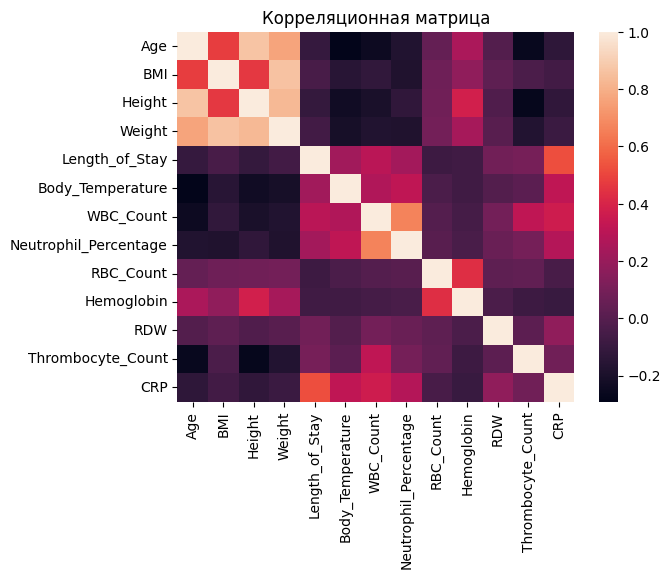

In [ ]:
# посмотрим матрицу корреляций
correlation_matrix = num_col.corr()
sns.heatmap(correlation_matrix)
plt.title('Корреляционная матрица')
plt.show()

удалим вес и рост, оставим индекс массы тела, а также удалим продолжительность нахождения в больнице

In [ ]:
df = df.drop (["Height", "Weight", "Length_of_Stay"], axis = 1)

In [ ]:
for col in num_col.columns:
    pct_missing = np.mean(num_col[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Age - 0%
BMI - 3%
Height - 3%
Weight - 0%
Length_of_Stay - 0%
Body_Temperature - 1%
WBC_Count - 1%
Neutrophil_Percentage - 13%
RBC_Count - 2%
Hemoglobin - 2%
RDW - 3%
Thrombocyte_Count - 2%
CRP - 1%


In [ ]:
num_col.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,781.0,11.346451,3.529909,0.00,9.2000,11.44,14.10,18.36
BMI,755.0,18.907012,4.385331,7.83,15.7250,18.06,21.18,38.16
Height,756.0,148.017460,19.732016,53.00,137.0000,149.65,163.00,192.00
Weight,779.0,43.172542,17.390984,3.96,29.5000,41.40,54.00,103.00
Length_of_Stay,778.0,4.284062,2.574057,1.00,3.0000,3.00,5.00,28.00
Body_Temperature,775.0,37.404516,0.903678,26.90,36.8000,37.20,37.90,40.20
WBC_Count,776.0,12.670683,5.366525,2.60,8.2000,12.00,16.20,37.70
Neutrophil_Percentage,679.0,71.791163,14.463656,27.20,61.4000,75.50,83.60,97.70
RBC_Count,764.0,4.799490,0.499012,3.62,4.5375,4.78,5.02,14.00
Hemoglobin,764.0,13.380497,1.393271,8.20,12.6000,13.30,14.00,36.00


не совсем понятно CRP 365 - это ошибка или на самом деле такой высокий результат (нужно со специалистом посоветоваться) - но вообще похоже на выброс

пока посмотрим на категориальные признаки

In [ ]:
char_col

,Sex,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Neutrophilia,Ketones_in_Urine,RBC_in_Urine,...,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Management,Severity,Diagnosis
0,female,no,yes,yes,no,no,yes,no,++,+,...,no,normal,no,yes,no,yes,no,conservative,uncomplicated,appendicitis
1,male,yes,yes,yes,no,no,yes,no,no,no,...,yes,normal,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
2,female,no,yes,yes,no,no,no,no,no,no,...,no,constipation,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
3,female,yes,yes,no,no,yes,yes,no,no,no,...,yes,normal,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
4,female,no,yes,yes,yes,yes,yes,no,no,no,...,no,constipation,no,yes,no,yes,no,conservative,uncomplicated,appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,female,yes,yes,no,no,no,yes,yes,NaN,NaN,...,no,diarrhea,local,yes,NaN,yes,no,primary surgical,uncomplicated,appendicitis
778,female,no,no,no,no,no,yes,yes,NaN,NaN,...,no,normal,local,no,NaN,yes,no,secondary surgical,complicated,appendicitis
779,female,no,yes,no,no,no,no,no,no,no,...,yes,normal,no,no,no,yes,yes,primary surgical,uncomplicated,appendicitis
780,male,yes,yes,no,yes,yes,no,yes,+++,no,...,no,normal,local,no,no,yes,yes,primary surgical,uncomplicated,appendicitis


In [ ]:
for col in char_col.columns:
    pct_missing = np.mean(char_col[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Sex - 0%
Migratory_Pain - 1%
Lower_Right_Abd_Pain - 1%
Contralateral_Rebound_Tenderness - 2%
Coughing_Pain - 2%
Nausea - 1%
Loss_of_Appetite - 1%
Neutrophilia - 6%
Ketones_in_Urine - 25%
RBC_in_Urine - 26%
WBC_in_Urine - 25%
Dysuria - 4%
Stool - 2%
Peritonitis - 1%
Psoas_Sign - 5%
Ipsilateral_Rebound_Tenderness - 21%
US_Performed - 0%
Free_Fluids - 8%
Management - 0%
Severity - 0%
Diagnosis - 0%


In [ ]:
char_col.describe().T

,count,unique,top,freq
Sex,780,2,male,403
Migratory_Pain,773,2,no,562
Lower_Right_Abd_Pain,774,2,yes,733
Contralateral_Rebound_Tenderness,767,2,no,469
Coughing_Pain,766,2,no,548
Nausea,774,2,yes,453
Loss_of_Appetite,772,2,yes,392
Neutrophilia,732,2,no,371
Ketones_in_Urine,582,4,no,332
RBC_in_Urine,576,4,no,442


In [ ]:
df.Ketones_in_Urine.value_counts()

,count
Ketones_in_Urine,
no,332
+++,124
+,77
++,49


пропуски заполняем средним соответствующим своей группе по таргету - если это числовой, модой тоже по такому принципу - если это категориальный.

среднее значение по числовым признакам

In [ ]:
# Заполнение пропусков средними значениями по группам
for column in df.select_dtypes(include=[np.number]).columns:
    df[column] = df.groupby('Diagnosis')[column].transform(lambda x: x.fillna(x.mean()))

мода по категориальным

In [ ]:
# Заполнение пропусков модой по группам
for column in df.select_dtypes(include=['object']):
    df[column] = df.groupby('Diagnosis')[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

обработаем выбросы

In [ ]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
df = remove_outlier(df, 'CRP')

In [ ]:
df

,Age,BMI,Sex,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,...,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Management,Severity,Diagnosis
0,12.68,16.90,female,no,yes,yes,no,no,yes,37.0,...,no,normal,no,yes,no,yes,no,conservative,uncomplicated,appendicitis
1,14.10,31.90,male,yes,yes,yes,no,no,yes,36.9,...,yes,normal,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
2,14.14,23.30,female,no,yes,yes,no,no,no,36.6,...,no,constipation,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
3,16.37,20.60,female,yes,yes,no,no,yes,yes,36.0,...,yes,normal,no,yes,no,yes,no,conservative,uncomplicated,no appendicitis
4,11.08,16.90,female,no,yes,yes,yes,yes,yes,36.9,...,no,constipation,no,yes,no,yes,no,conservative,uncomplicated,appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,14.35,19.74,female,no,yes,no,yes,yes,yes,38.0,...,no,diarrhea,local,yes,no,yes,no,secondary surgical,uncomplicated,appendicitis
777,12.41,25.25,female,yes,yes,no,no,no,yes,39.4,...,no,diarrhea,local,yes,no,yes,no,primary surgical,uncomplicated,appendicitis
779,14.99,19.91,female,no,yes,no,no,no,no,37.3,...,yes,normal,no,no,no,yes,yes,primary surgical,uncomplicated,appendicitis
780,7.20,14.30,male,yes,yes,no,yes,yes,no,37.5,...,no,normal,local,no,no,yes,yes,primary surgical,uncomplicated,appendicitis


смотрим еще раз на датасет

In [ ]:
print("Размер датасета:", df.shape)
print("Количество дубликатов:", df.duplicated().sum())
print("Содержит NaN:", df.isnull().any().any())
print("Пропущенные значения:")
print(df.isnull().sum())
df[df.isnull().all(axis=1)]

Размер датасета: (696, 31)
Количество дубликатов: 0
Содержит NaN: False
Пропущенные значения:
Age                                 0
BMI                                 0
Sex                                 0
Migratory_Pain                      0
Lower_Right_Abd_Pain                0
Contralateral_Rebound_Tenderness    0
Coughing_Pain                       0
Nausea                              0
Loss_of_Appetite                    0
Body_Temperature                    0
WBC_Count                           0
Neutrophil_Percentage               0
Neutrophilia                        0
RBC_Count                           0
Hemoglobin                          0
RDW                                 0
Thrombocyte_Count                   0
Ketones_in_Urine                    0
RBC_in_Urine                        0
WBC_in_Urine                        0
CRP                                 0
Dysuria                             0
Stool                               0
Peritonitis                     

,Age,BMI,Sex,Migratory_Pain,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Coughing_Pain,Nausea,Loss_of_Appetite,Body_Temperature,...,Dysuria,Stool,Peritonitis,Psoas_Sign,Ipsilateral_Rebound_Tenderness,US_Performed,Free_Fluids,Management,Severity,Diagnosis


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 0 to 781
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               696 non-null    float64
 1   BMI                               696 non-null    float64
 2   Sex                               696 non-null    object 
 3   Migratory_Pain                    696 non-null    object 
 4   Lower_Right_Abd_Pain              696 non-null    object 
 5   Contralateral_Rebound_Tenderness  696 non-null    object 
 6   Coughing_Pain                     696 non-null    object 
 7   Nausea                            696 non-null    object 
 8   Loss_of_Appetite                  696 non-null    object 
 9   Body_Temperature                  696 non-null    float64
 10  WBC_Count                         696 non-null    float64
 11  Neutrophil_Percentage             696 non-null    float64
 12  Neutrophilia 

осталось обработать категориальные признаки

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
label_encoder = LabelEncoder()

categorical_cols = df.select_dtypes(include=['object']).columns.to_list()

for col in categorical_cols:
  df[col] = df[col].astype('str')
  df[col] = label_encoder.fit_transform(df[col])

In [ ]:
categorical_cols

['Sex',
 'Migratory_Pain',
 'Lower_Right_Abd_Pain',
 'Contralateral_Rebound_Tenderness',
 'Coughing_Pain',
 'Nausea',
 'Loss_of_Appetite',
 'Neutrophilia',
 'Ketones_in_Urine',
 'RBC_in_Urine',
 'WBC_in_Urine',
 'Dysuria',
 'Stool',
 'Peritonitis',
 'Psoas_Sign',
 'Ipsilateral_Rebound_Tenderness',
 'US_Performed',
 'Free_Fluids',
 'Management',
 'Severity',
 'Diagnosis']

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,696.0,11.448819,3.431567,0.00,9.2775,11.480000,14.100,18.36
BMI,696.0,18.947233,4.315730,7.83,15.8700,18.310000,21.005,38.16
Sex,696.0,0.511494,0.500227,0.00,0.0000,1.000000,1.000,1.00
Migratory_Pain,696.0,0.275862,0.447269,0.00,0.0000,0.000000,1.000,1.00
Lower_Right_Abd_Pain,696.0,0.952586,0.212675,0.00,1.0000,1.000000,1.000,1.00
Contralateral_Rebound_Tenderness,696.0,0.367816,0.482558,0.00,0.0000,0.000000,1.000,1.00
Coughing_Pain,696.0,0.278736,0.448700,0.00,0.0000,0.000000,1.000,1.00
Nausea,696.0,0.556034,0.497208,0.00,0.0000,1.000000,1.000,1.00
Loss_of_Appetite,696.0,0.485632,0.500153,0.00,0.0000,0.000000,1.000,1.00
Body_Temperature,696.0,37.330919,0.873037,26.90,36.8000,37.200000,37.800,40.20


надо масштабировать, и похоже еще есть выбросы в признаке Thrombocyte_Count, хотя возможно это мед аномалия и надо с ней разбираться отдельно

In [ ]:
df.Thrombocyte_Count.value_counts()

,count
Thrombocyte_Count,
285.793333,12
234.000000,9
223.000000,8
305.000000,8
221.000000,8
...,...
134.000000,1
443.000000,1
362.000000,1


In [ ]:
df = remove_outlier(df, 'Thrombocyte_Count')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688 entries, 0 to 781
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               688 non-null    float64
 1   BMI                               688 non-null    float64
 2   Sex                               688 non-null    int64  
 3   Migratory_Pain                    688 non-null    int64  
 4   Lower_Right_Abd_Pain              688 non-null    int64  
 5   Contralateral_Rebound_Tenderness  688 non-null    int64  
 6   Coughing_Pain                     688 non-null    int64  
 7   Nausea                            688 non-null    int64  
 8   Loss_of_Appetite                  688 non-null    int64  
 9   Body_Temperature                  688 non-null    float64
 10  WBC_Count                         688 non-null    float64
 11  Neutrophil_Percentage             688 non-null    float64
 12  Neutrophilia 

датасет обработан и готов к работе

# ML

In [ ]:
!pip install catboost >> None

In [ ]:
import catboost

In [ ]:
X = df.drop(['Diagnosis', 'Severity', 'Management'], axis=1)
y = df['Diagnosis']

In [ ]:
y.value_counts()

,count
Diagnosis,
0,380
1,308


классы сбалансированы?

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 688 entries, 0 to 781
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               688 non-null    float64
 1   BMI                               688 non-null    float64
 2   Sex                               688 non-null    int64  
 3   Migratory_Pain                    688 non-null    int64  
 4   Lower_Right_Abd_Pain              688 non-null    int64  
 5   Contralateral_Rebound_Tenderness  688 non-null    int64  
 6   Coughing_Pain                     688 non-null    int64  
 7   Nausea                            688 non-null    int64  
 8   Loss_of_Appetite                  688 non-null    int64  
 9   Body_Temperature                  688 non-null    float64
 10  WBC_Count                         688 non-null    float64
 11  Neutrophil_Percentage             688 non-null    float64
 12  Neutrophilia 

масштабируем

In [ ]:
X_scaled = StandardScaler().fit_transform(X)

## Разделяем данные на обучающую и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

In [ ]:
y_test.value_counts()

,count
Diagnosis,
0,156
1,120


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Модели

LogisticRegression

RandomForestClassifier

GradientBoostingClassifier

CatBoostClassifier

In [ ]:
models = []
# Appending models into the list
models.append(("LogisticRegression", LogisticRegression(random_state=42)))
models.append(("Random forest", RandomForestClassifier(random_state=42)))
models.append(("GradientBoosting", GradientBoostingClassifier(random_state=42)))
models.append(("CatBoost", catboost.CatBoostClassifier(verbose=False)))


print("\n" "Результаты f1:" "\n")

for name, model in models:
    model.fit(X_test, y_test)
    scores_val = f1_score(y_test, model.predict(X_test), average = 'binary')
    print("{}: {}".format(name, scores_val))


Результаты f1:

LogisticRegression: 0.7364016736401674
Random forest: 1.0
GradientBoosting: 1.0
CatBoost: 1.0


Получается, что три модели очень хороши предсказывают диагноз, возможно все таки надо еще более пристально поработать с признаками (поискать со специалистом)

## Важность признаков для RandomForestClassifier

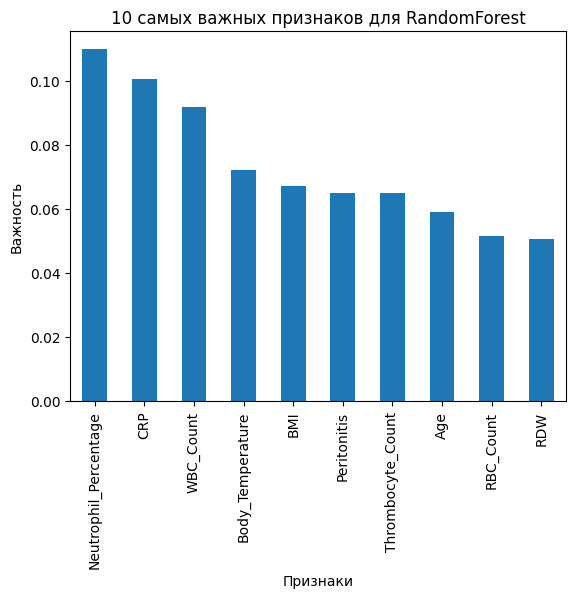

In [ ]:
model_best = RandomForestClassifier(random_state=42)
model_best.fit(X_train, y_train)
# Получение важности признаков
importances = model_best.feature_importances_
# vals = [f'Feature {i}' for i in range(X.shape[1])]  # Названия признаков
vals = [column for column in X.columns]  # Названия признаков
# Создание DataFrame для визуализации
importance_df = pd.DataFrame({'Feature': vals, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Отбор только 10 самых важных признаков
top_10_importance_df = importance_df.head(10)

# Построение графика важности признаков
top_10_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('10 самых важных признаков для RandomForest')
plt.ylabel('Важность')
plt.xlabel('Признаки')
plt.show()

Хотя, с другой стороны, судя по важности признаков модель RF похоже основывается на результатах анализов

Посмотрим важность для GradientBoostingClassifier

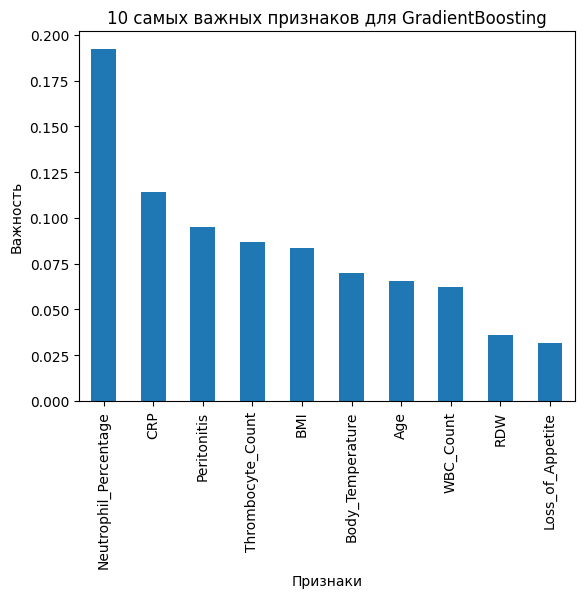

In [ ]:
model_best_gr = GradientBoostingClassifier(random_state=42)
model_best_gr.fit(X_train, y_train)
# Получение важности признаков
importances_gr = model_best_gr.feature_importances_
# vals = [f'Feature {i}' for i in range(X.shape[1])]  # Названия признаков
vals = [column for column in X.columns]  # Названия признаков
# Создание DataFrame для визуализации
importance_df_gr = pd.DataFrame({'Feature': vals, 'Importance': importances_gr}).sort_values(by='Importance', ascending=False)

# Отбор только 10 самых важных признаков
top_10_importance_df_gr = importance_df_gr.head(10)

# Построение графика важности признаков
top_10_importance_df_gr.plot(kind='bar', x='Feature', y='Importance', legend=False)
plt.title('10 самых важных признаков для GradientBoosting')
plt.ylabel('Важность')
plt.xlabel('Признаки')
plt.show()

почти те же самые признаки

## Матрицы ошибок

LogisticRegression


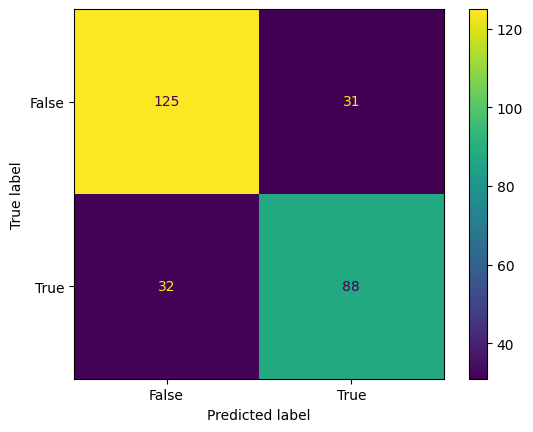

Random forest


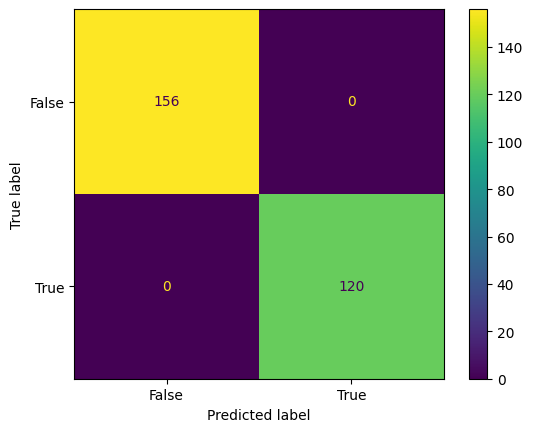

GradientBoosting


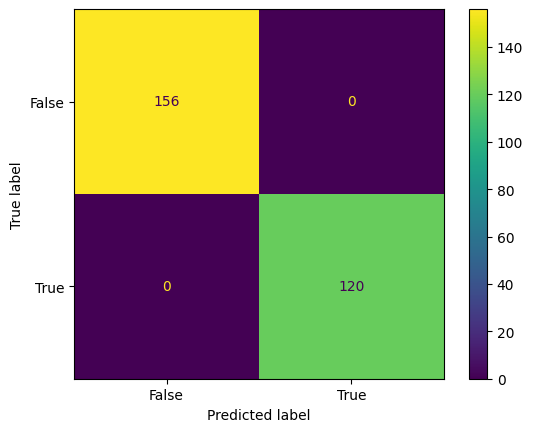

CatBoost


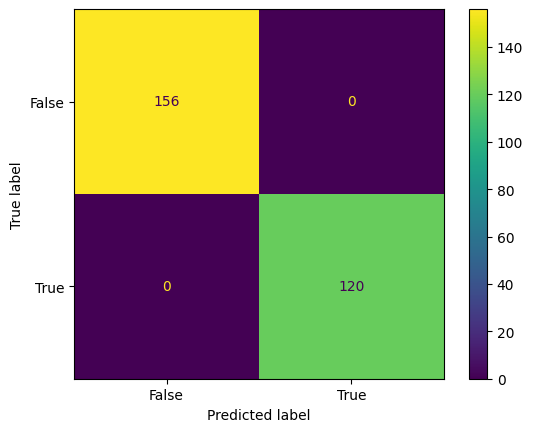

In [ ]:
for name, model in models:
  cm = confusion_matrix(y_test, model.predict(X_test))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
  disp.plot()
  print(name)
  plt.show()

## График функции потерь

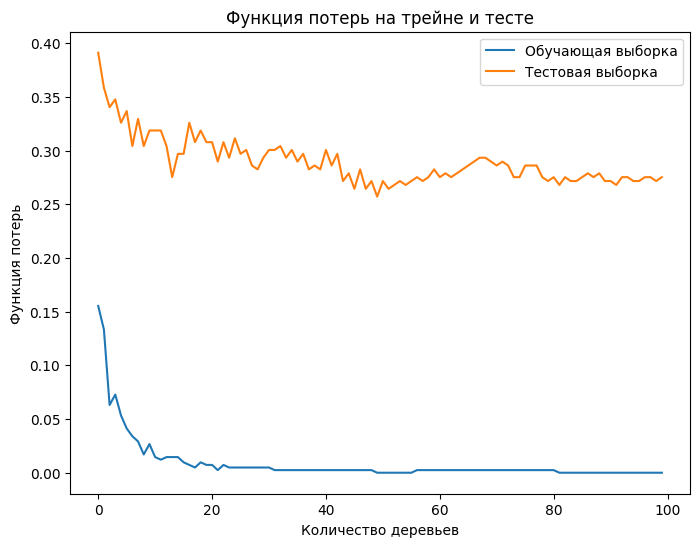

In [ ]:
error_rate_train = []
error_rate_test = []
n_estimators = 100

rf_best_model = RandomForestClassifier(random_state=42)

for i in range(1, n_estimators + 1):
  rf_best_model.set_params(n_estimators=i)
  rf_best_model.fit(X_train, y_train)
  train_loss = 1 - rf_best_model.score(X_train, y_train)
  error_rate_train.append(train_loss)
  y_pred = rf_best_model.predict(X_test)
  test_loss = 1 - accuracy_score(y_test, y_pred)
  error_rate_test.append(test_loss)

plt.figure(figsize=(8, 6))
plt.plot(error_rate_train, label='Обучающая выборка')
plt.plot(error_rate_test, label='Тестовая выборка')
plt.xlabel('Количество деревьев')
plt.ylabel('Функция потерь')
plt.title('Функция потерь на трейне и тесте')
plt.legend()
plt.show()

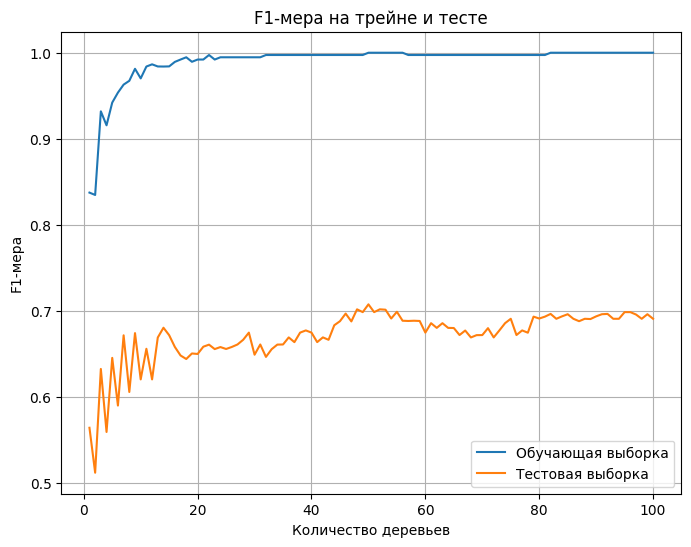

In [ ]:
# Инициализация переменных для хранения F1-меры
f1_train = []
f1_test = []
n_estimators = 100

# Инициализация модели RandomForestClassifier
rf_best_model = RandomForestClassifier(random_state=42)

# Обучение модели с различным количеством деревьев
for i in range(1, n_estimators + 1):
    rf_best_model.set_params(n_estimators=i)
    rf_best_model.fit(X_train, y_train)

    # Предсказания на обучающей выборке
    y_train_pred = rf_best_model.predict(X_train)
    train_f1 = f1_score(y_train, y_train_pred)
    f1_train.append(train_f1)

    # Предсказания на тестовой выборке
    y_test_pred = rf_best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    f1_test.append(test_f1)

# Построение графиков F1-меры на обучающей и тестовой выборках
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_estimators + 1), f1_train, label='Обучающая выборка')
plt.plot(range(1, n_estimators + 1), f1_test, label='Тестовая выборка')
plt.xlabel('Количество деревьев')
plt.ylabel('F1-мера')
plt.title('F1-мера на трейне и тесте')
plt.legend()
plt.grid()
plt.show()

получается, что для стабилизации процесса обучения модели достаточно примерно 30 деревьев?

# Keras

In [ ]:
!pip install keras >> None

In [ ]:
import keras
import tensorflow
from keras.models import Sequential
# from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Neural Network Model
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # reduce
    model.add(Dropout(0.3))  # отсев для проблемы переобучения
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # выходной слой для бинарной классификации

    # компиляция модели
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
# создание модели
nn_model = create_nn_model(input_dim)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # ранняя остановка для
                                                                                          # решения проблемы переобучения

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,025 (19.63 KB)

 Trainable params: 5,025 (19.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# тренировка модели
# nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=0)
# nn_model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[early_stopping], verbose=0)
# nn_model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)
history  = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5183 - loss: 0.6915 - val_accuracy: 0.6630 - val_loss: 0.6492
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6139 - loss: 0.6499 - val_accuracy: 0.7029 - val_loss: 0.6220
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6106 - loss: 0.6359 - val_accuracy: 0.7101 - val_loss: 0.5974
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7245 - loss: 0.5825 - val_accuracy: 0.6920 - val_loss: 0.5753
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7244 - loss: 0.5722 - val_accuracy: 0.7029 - val_loss: 0.5568
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6971 - loss: 0.5728 - val_accuracy: 0.7029 - val_loss: 0.5502
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7344 - loss: 0.5507 - val_accuracy: 0.7029 - val_loss: 0.5527
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7665 - loss: 0.5068 - val_accuracy: 0.7138

In [ ]:
# предсказание
y_pred_proba_nn = nn_model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
y_pred_proba_nn

array([[0.291363  ],
       [0.6372452 ],
       [0.24987115],
       [0.52555937],
       [0.40686172],
       [0.8388513 ],
       [0.3197669 ],
       [0.6294728 ],
       [0.12860255],
       [0.6594415 ],
       [0.11700974],
       [0.275954  ],
       [0.10081186],
       [0.6776712 ],
       [0.02275411],
       [0.03088756],
       [0.5329758 ],
       [0.55126727],
       [0.1286824 ],
       [0.83445126],
       [0.5031123 ],
       [0.36229104],
       [0.07883239],
       [0.03683982],
       [0.635756  ],
       [0.78502226],
       [0.69931513],
       [0.45533556],
       [0.45942533],
       [0.24657609],
       [0.27941367],
       [0.16504931],
       [0.54814714],
       [0.4017537 ],
       [0.2700925 ],
       [0.5132371 ],
       [0.75090814],
       [0.7920681 ],
       [0.27259746],
       [0.26214203],
       [0.8218944 ],
       [0.18995954],
       [0.5270719 ],
       [0.6759674 ],
       [0.743962  ],
       [0.07141832],
       [0.08519157],
       [0.518

In [ ]:
# округление до целых
y_pred_binary = (y_pred_proba_nn >= 0.5).astype(int)

## Метрики

In [ ]:
print("accuracy:", accuracy_score(y_test, y_pred_binary))
print("precision:", precision_score(y_test, y_pred_binary, average = 'binary'))
print("recall:", recall_score(y_test, y_pred_binary, average = 'binary'))
print("f1:", f1_score(y_test, y_pred_binary, average = 'binary'))

accuracy: 0.7210144927536232
precision: 0.6616541353383458
recall: 0.7333333333333333
f1: 0.6956521739130435


## Матрица ошибок

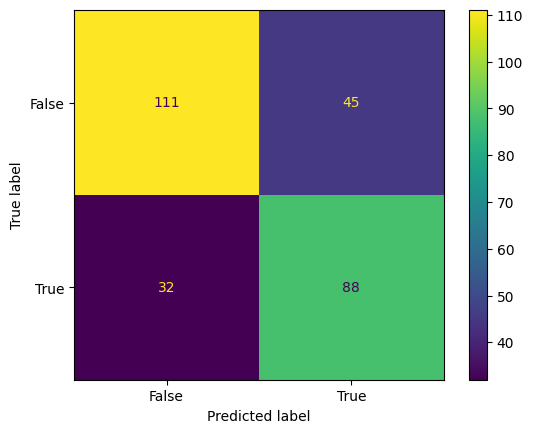

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
disp.plot()
plt.show()

## График функции потерь

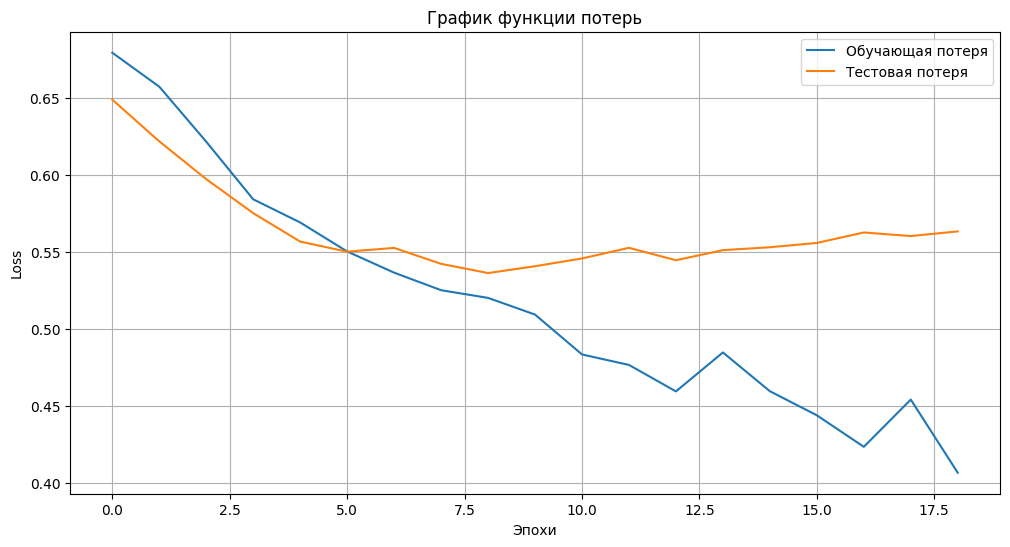

In [ ]:
# # Обучение модели и сохранение истории
# # history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
# history  = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Построение графика функции потерь
plt.figure(figsize=(12, 6))

# График потерь на обучающей выборке
plt.plot(history.history['loss'], label='Обучающая потеря')
# # График потерь на тестовой выборке
plt.plot(history.history['val_loss'], label='Тестовая потеря')

plt.title('График функции потерь')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
history.history

{'accuracy': [0.5485436916351318,
  0.594660222530365,
  0.6480582356452942,
  0.7208737730979919,
  0.7184466123580933,
  0.7233009934425354,
  0.7305825352668762,
  0.7305825352668762,
  0.737864077091217,
  0.7548543810844421,
  0.7645630836486816,
  0.7718446850776672,
  0.791262149810791,
  0.7669903039932251,
  0.791262149810791,
  0.803398072719574,
  0.8082524538040161,
  0.7694174647331238,
  0.8179611563682556],
 'loss': [0.6796894073486328,
  0.6575978994369507,
  0.6217923760414124,
  0.5843111276626587,
  0.5692319869995117,
  0.5503581166267395,
  0.5365797877311707,
  0.525153636932373,
  0.5201559662818909,
  0.5093023777008057,
  0.4833483397960663,
  0.4765206575393677,
  0.45929890871047974,
  0.484637051820755,
  0.45942991971969604,
  0.44374728202819824,
  0.4232495427131653,
  0.4539738893508911,
  0.40638306736946106],
 'val_accuracy': [0.6630434989929199,
  0.7028985619544983,
  0.7101449370384216,
  0.6920289993286133,
  0.7028985619544983,
  0.702898561954498

# Вывод

RandomForest, CatBoost и GradientBoosting даже после нескольких вариантов работы с признаками показали идеальные результаты. Возможно они переобучены, так как в датасете скорее всего остались прямо коррелирующие признаки.
Keras возможно как раз демонстрирует более близкие к реальности результаты (совершенно не впечатляющие), или требуются более тонкие настройки.
Самым важным признаком является Neutrophil_Percentage - результат анализа крови. Аппендицит так и диагностируется в том числе на основании анализов при подозрении.
